In [1]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset 
import matplotlib.pyplot as plt
#import nltk
#nltk.download('wordnet')
import numpy as np 
import torch
import json
import networkx as nx
import pandas as pd
from utils.bag_of_words.skill_dataset import *
cognitive_skills_community = {
                    "cognitive_process_memory":[ 
                        "sustained_attention", "selective_attention", "divided_attention", "vigilance_attention","attention_shifting",
                        "processing_speed", "visual_processing_speed", "auditory_processing_speed",
                        "prospective_memory", "working_memory", "episodic_memory", "semantic_memory", "procedural_memory", "iconic_memory", "echoic_memory", "spatial_memory"],
                    "executive_function":[ 
                        "planning", "organization", "goal_setting","time_management", 
                        "problem_solving", "mental_flexibility", "strategic_thinking","adaptability",
                        "impulse_control", "decision_making","emotional_regulation","risk_assessment",
                        "abstract_thinking", "reasoning"," concept_formation", "cognitive_flexibility", "creativity"],
                    "language_communication":[
                         "expressive_language", "receptive_language", "naming", "fluency", "comprehension", "repetition", "reading", "writing", 
                         "pragmatics", "discourse_ability", "expressive_language", "receptive_language", "linguistic_analysis", "narrative_skills"],
                    "social_cognition":
                        ["recognition_of_social_cues", "theory_of_mind", "empathy", "social_judgment","intercultural_competence","conflict_resolution","self_awareness","relationship_management"]
}


# Dataset

In [2]:
with open("result/dataMultidisciplinaryCognitiveSkillsFrameworkRestrict.json", 'r') as openfile:
    #with open("result/dataNeuropsychologicalDomains.json", 'r') as openfile:
    #with open("result/dataCategory.json", 'r') as openfile:
    # Reading from json file
    dataCategory = json.load(openfile)
total_skill= 0 
for d in dataCategory:
    total_skill += len(dataCategory[d])
print(total_skill)
'''dataCategory = filterData(dataCategory, 0.75)#0.3
total_skill= 0 
for d in dataCategory:
    total_skill += len(dataCategory[d])
print(total_skill)'''
'''
dataCategory = td_idf_filter(dataCategory)
total_skill= 0 
for d in dataCategory:
    total_skill += len(dataCategory[d])
print(total_skill)'''

62736


'\ndataCategory = td_idf_filter(dataCategory)\ntotal_skill= 0 \nfor d in dataCategory:\n    total_skill += len(dataCategory[d])\nprint(total_skill)'

In [3]:
'''for node_i in dataCategory:
    items_i =  np.unique(np.array(dataCategory[node_i]))
    frequency_i = [(x,dataCategory[node_i].count(x)) for x in items_i]
    get_node_i = sorted(frequency_i,key=lambda x: x[1], reverse=True)[0:20]
    print(get_node_i)
    get_node_i = [key[0] for key in get_node_i]
    print(node_i, get_node_i)'''

'for node_i in dataCategory:\n    items_i =  np.unique(np.array(dataCategory[node_i]))\n    frequency_i = [(x,dataCategory[node_i].count(x)) for x in items_i]\n    get_node_i = sorted(frequency_i,key=lambda x: x[1], reverse=True)[0:20]\n    print(get_node_i)\n    get_node_i = [key[0] for key in get_node_i]\n    print(node_i, get_node_i)'

# Create Network

In [4]:
#Nodes = tokens
#Edges = Common tokens between different datasets
def create_graph(dataCategory):
    filter = None #just get top 50
    edges = []
    G =nx.Graph()
    dataset = list(dataCategory.keys())
    other_dataset = list(dataCategory.keys())
    for node_i in dataset:
        other_dataset.remove(node_i)
        if filter != None:
            items_i =  np.unique(np.array(dataCategory[node_i]))
            frequency_i = [(x,dataCategory[node_i].count(x)) for x in items_i]
            get_node_i = sorted(frequency_i,key=lambda x: x[1], reverse=True)[0:filter]
            get_node_i = [key[0] for key in get_node_i]
        else:
            get_node_i = dataCategory[node_i]
        for node_j in other_dataset:
            if filter != None:
                items_j =  np.unique(np.array(dataCategory[node_j]))
                frequency_j = [(x,dataCategory[node_j].count(x)) for x in items_j]
                get_node_j = sorted(frequency_j,key=lambda x: x[1], reverse=True)[0:filter]
                get_node_j = [key[0] for key in get_node_j]
            else:
                get_node_j = dataCategory[node_j]
            common = list(set(get_node_i).intersection(get_node_j))
            #if len(common) == 0:
            #    continue
            if len(common) >= 1: #15
                G.add_edge(node_i, node_j, weight=len(common))
    return G


## Open Network

In [5]:
def plot_degree_dist(G,title):
    degrees = sorted([G.degree(n) for n in G.nodes()])
    plt.hist(degrees)
    plt.title("Degree Distribution of "+title)
    plt.show()
def draw_regular_network(G):
    #G.remove_edges_from(nx.selfloop_edges(G))
    print(G)
    nx.write_edgelist(G, "network_words.txt")
    plot_degree_dist(G, f"{G}")

    print(G)

    plt.figure(figsize=(20, 20), dpi=100)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    pos = nx.spring_layout(G, k=0.8, iterations=20)
    d = dict(G.degree)
    nx.draw(G, pos, node_color='b',nodelist=d.keys(),node_size=[v * 10 for v in d.values()],with_labels = True, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues)
    plt.title(f"{G}",fontsize = 40)
    plt.show()
    plot_degree_dist(G,G)

## Community Detection

In [6]:
from community import community_louvain
from copy import deepcopy
from utils.bag_of_words.community_layout import *
from utils.bag_of_words.network_property import *
def test(g):
    comm, partition = get_community(g)
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
    pos = community_layout(deepcopy(g), partition)
    plt.figure(figsize=(10,10),dpi=100)
    d = dict(g.degree)
    #nx.draw(g, pos, node_size=[v * 15 for v in d.values()], node_color=list(partition.values())); plt.show()
    nx.draw(g, pos, node_color=list(partition.values()),nodelist=d.keys(),node_size=[v * 5 for v in d.values()],with_labels = True, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues)
    return g, comm 
for filter in list(range(10,100,5))+[99,100,None]:
    if filter!=None:
        filter = filter/100
        dataCategoryX = filterData(dataCategory, filter)#0.3
    else:
        dataCategoryX = dataCategory
    G = create_graph(dataCategoryX)
    communities, partition = get_community(G)
    print(filter,"\t| ",nx.density(G),"\t| ",[f"{i}: {len(communities[i])}" for i in communities])
'''print(G)
G, communities = test(G)
print([f"{i}: {len(communities[i])}" for i in communities])'''

0.1 	|  0.4576719576719577 	|  ['0: 9', '1: 9', '2: 10']
0.15 	|  0.36594493450948945 	|  ['0: 25', '1: 19', '2: 12', '3: 31']
0.2 	|  0.4053305642090689 	|  ['0: 31', '1: 27', '2: 30', '3: 20']
0.25 	|  0.4886710239651416 	|  ['0: 31', '1: 32', '2: 15', '3: 58']
0.3 	|  0.5151352511807643 	|  ['0: 63', '1: 30', '2: 44']
0.35 	|  0.6058731265249215 	|  ['0: 45', '1: 55', '2: 52']
0.4 	|  0.7070918404155544 	|  ['0: 35', '1: 28', '2: 57', '3: 47']
0.45 	|  0.7521823822235048 	|  ['0: 64', '1: 49', '2: 54']
0.5 	|  0.8665290677674579 	|  ['0: 77', '1: 20', '2: 74']
0.55 	|  0.8754041967664259 	|  ['0: 77', '1: 19', '2: 75']
0.6 	|  0.904288210781019 	|  ['0: 71', '1: 55', '2: 47']
0.65 	|  0.904288210781019 	|  ['0: 71', '1: 55', '2: 47']
0.7 	|  0.9217636779136981 	|  ['0: 64', '1: 69', '2: 40']
0.75 	|  0.9818616703209089 	|  ['0: 67', '1: 60', '2: 47']
0.8 	|  0.9865125240847784 	|  ['0: 72', '1: 44', '2: 58']
0.85 	|  0.9887715101986579 	|  ['0: 72', '1: 44', '2: 58']
0.9 	|  0.98877

'print(G)\nG, communities = test(G)\nprint([f"{i}: {len(communities[i])}" for i in communities])'

## Skills within Communities

In [7]:
def topSkills(dict_of_lists, top=10):
    from collections import Counter

    # Flatten the lists into a single list
    all_elements = [item for sublist in dict_of_lists.values() for item in sublist]

    # Count the occurrences of each element
    element_counts = Counter(all_elements)

    # Get the 10 most common elements
    most_common_elements = element_counts.most_common(top)

    '''print("10 Most Common Elements:")
    for element, count in most_common_elements:
        print(f"{element}: {count} occurrences")'''
    return most_common_elements


In [8]:

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
uniqueCategory = dataCategory #filterData(dataCategory, 1.0)
different = set(uniqueCategory.keys()).difference(G.nodes)
dict_of_lists = {}
for idx, comm in enumerate(communities):
    print(comm)
    dict_of_lists[comm] = {}
    for node in communities[comm]:
        items =  np.unique(np.array(uniqueCategory[node]))
        frequency = [(x,uniqueCategory[node].count(x)) for x in items]
        get_node = sorted(frequency,key=lambda x: x[1], reverse=True)#[0:20]
        get_node = [key[0] for key in get_node]
        print("\t",node,"\t",get_node)
        dict_of_lists[comm][node] = get_node
    
    
print(idx+1)
dict_of_lists[idx+1] = {}
for node in different:
        items =  np.unique(np.array(uniqueCategory[node]))
        frequency = [(x,uniqueCategory[node].count(x)) for x in items]
        get_node = sorted(frequency,key=lambda x: x[1], reverse=True)#[0:20]
        get_node = [key[0] for key in get_node]
        print("\t",node,"\t",get_node)
        dict_of_lists[idx+1][node] = get_node
json_object = json.dumps(dict_of_lists, cls=NumpyEncoder)
with open("result/dataNeuropsychologicalDomainsCluster.json", "w") as outfile:
#with open("result/dataCategoryCluster.json", "w") as outfile:
    outfile.write(json_object)

0
	 checkmate_in_one 	 ['problem_solving', 'attention_shifting', 'reasoning', 'cognitive_flexibility', 'spatial_memory', 'working_memory', 'strategic_thinking', 'planning', 'visual_processing_speed', 'decision_making', 'selective_attention', 'mental_flexibility', 'episodic_memory', 'iconic_memory', 'processing_speed', 'prospective_memory', 'recognition_of_social_cues']
	 cifar10_classification 	 ['visual_processing_speed', 'problem_solving', 'working_memory', 'attention_shifting', 'linguistic_analysis', 'recognition_of_social_cues', 'reasoning', 'semantic_memory', 'selective_attention', 'cognitive_flexibility', 'divided_attention', 'processing_speed', 'decision_making', 'iconic_memory', 'episodic_memory', 'prospective_memory', 'spatial_memory', 'procedural_memory', 'reading', 'auditory_processing_speed', 'comprehension', 'emotional_regulation', 'strategic_thinking']
	 color 	 ['reasoning', 'visual_processing_speed', 'attention_shifting', 'problem_solving', 'linguistic_analysis', 'recog

In [9]:
for comm in dict_of_lists:
    skills = topSkills(dict_of_lists[comm], 50)
    print(comm, [f"({skill[0]} {skill[1]})" for skill in skills])
    print(comm, list(dict_of_lists[comm].keys()))
    print("+"*100)

0 ['(problem_solving 43)', '(attention_shifting 43)', '(reasoning 43)', '(cognitive_flexibility 43)', '(working_memory 42)', '(spatial_memory 38)', '(selective_attention 36)', '(processing_speed 35)', '(linguistic_analysis 34)', '(semantic_memory 34)', '(planning 32)', '(organization 30)', '(visual_processing_speed 28)', '(decision_making 27)', '(episodic_memory 27)', '(reading 27)', '(abstract_thinking 27)', '(recognition_of_social_cues 22)', '(comprehension 22)', '(strategic_thinking 21)', '(sustained_attention 21)', '(mental_flexibility 19)', '(expressive_language 18)', '(procedural_memory 15)', '(time_management 14)', '(prospective_memory 13)', '(divided_attention 13)', '(creativity 11)', '(iconic_memory 10)', '(adaptability 9)', '(auditory_processing_speed 8)', '(naming 8)', '(theory_of_mind 8)', '(goal_setting 5)', '(empathy 4)', '(receptive_language 4)', '(risk_assessment 4)', '(vigilance_attention 3)', '(writing 3)', '(emotional_regulation 2)', '(discourse_ability 2)', '(repeti

## Skills within and between Communities

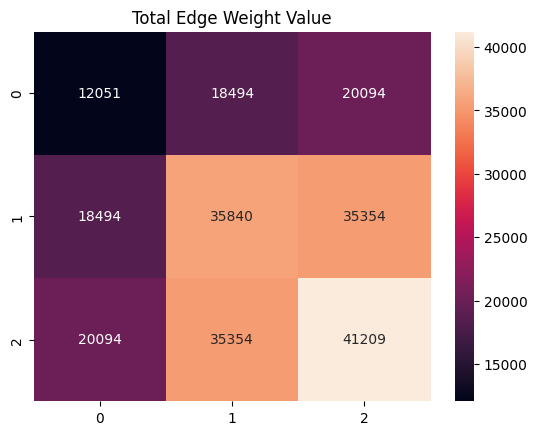

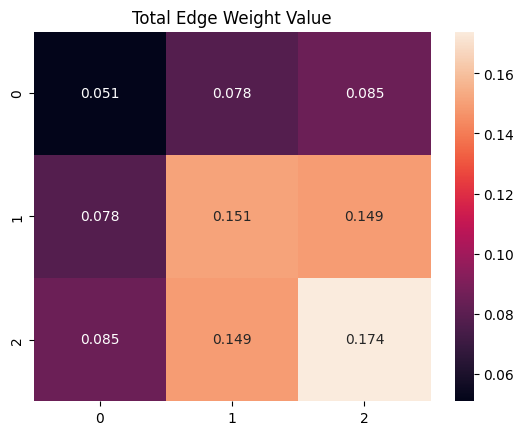

In [10]:
def total_edge_weight_between_communities(graph, community1, community2):
    total_weight = 0
    for node1 in community1:
        for node2 in community2:
            if graph.has_edge(node1, node2):
                total_weight += graph[node1][node2]['weight']  # Assuming the graph is weighted
    return total_weight
edge_weight_label = []
edge_weight = np.zeros((len(dict_of_lists)-1,len(dict_of_lists)-1))
for idx1, community_name1 in enumerate(dict_of_lists):
    if community_name1 == list(dict_of_lists.keys())[-1]:
        continue
    community_node1 = list(dict_of_lists[community_name1].keys())
    edge_weight_comm = []
    for idx2, community_name2 in enumerate(dict_of_lists):
        if community_name2 == list(dict_of_lists.keys())[-1]:
            continue
        community_node2 = list(dict_of_lists[community_name2].keys())
        
        edge_weight_comm.append(f"{(len(community_node1),len(community_node2))}: {str(total_edge_weight_between_communities(G, community_node1, community_node2)/2)}")
        edge_weight[idx1,idx2] = total_edge_weight_between_communities(G, community_node1, community_node2)/2
    edge_weight_label.append(edge_weight_comm)
#diagonal means within communities
total_weight = G.size(weight="weight")
sns.heatmap(edge_weight, annot=True, fmt=".0f")
plt.title("Total Edge Weight Value")
plt.show()
edge_weight = np.array(edge_weight)/total_weight
sns.heatmap(edge_weight, annot=True, fmt=".3f")

plt.title("Total Edge Weight Value")
plt.show()